Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модели на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей 
    
    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

Необходимые импорты

In [147]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product

Берем датасет амазона

In [148]:
data_frame = pd.read_csv('./Amazon_Historical_StockPrice2.csv')
data_frame.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400
5,2016-04-04,599.000000,599.500000,590.549988,593.190002,593.190002,2470800
6,2016-04-05,590.770020,593.469971,585.250000,586.140015,586.140015,2308900
7,2016-04-06,587.520020,602.390015,587.500000,602.080017,602.080017,2849900
8,2016-04-07,598.760010,599.599976,589.080017,591.429993,591.429993,3189000
9,2016-04-08,594.320007,597.859985,589.000000,594.599976,594.599976,2591900


In [149]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [150]:
data_frame.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1677.254199,1694.635633,1657.249580,1676.504673,1676.504673,4.318210e+06
std,787.593224,798.250932,774.769809,786.149289,786.149289,2.089566e+06
min,580.150024,584.750000,575.559998,579.869995,579.869995,8.813000e+05
25%,967.990005,974.467499,959.544983,966.027512,966.027512,2.908675e+06
50%,1676.494995,1698.104980,1654.445007,1671.174988,1671.174988,3.716250e+06
75%,1932.977478,1951.877502,1908.004974,1928.965027,1928.965027,5.122475e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.656500e+07


Данные распределим по месяцам, столбец Date должен стать датой

In [151]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'], format='%Y.%m.%d %H:%M:%S')
data_frame = data_frame.sort_values(by='Date').set_index('Date').groupby(pd.Grouper(freq='M')).mean()
data_frame.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-31,590.135025,596.147491,584.817505,591.514999,591.514999,3.521600e+06
2016-04-30,613.530951,619.647618,607.133333,613.594288,613.594288,3.736390e+06
2016-05-31,694.639526,702.979042,690.159526,697.473807,697.473807,4.314976e+06
2016-06-30,716.122273,721.051364,710.848172,716.390453,716.390453,3.388223e+06
2016-07-31,741.990997,746.521500,735.735999,741.467499,741.467499,3.431775e+06
2016-08-31,764.291737,767.613037,760.904347,764.839127,764.839127,2.173930e+06
2016-09-30,786.408096,793.094761,782.495716,788.965233,788.965233,3.206462e+06
2016-10-31,826.923334,830.645711,819.910473,824.439055,824.439055,3.669705e+06
2016-11-30,766.715233,772.941432,755.452381,763.335240,763.335240,5.242186e+06


Начало анализа

<AxesSubplot:title={'center':'Residual'}, xlabel='Date'>

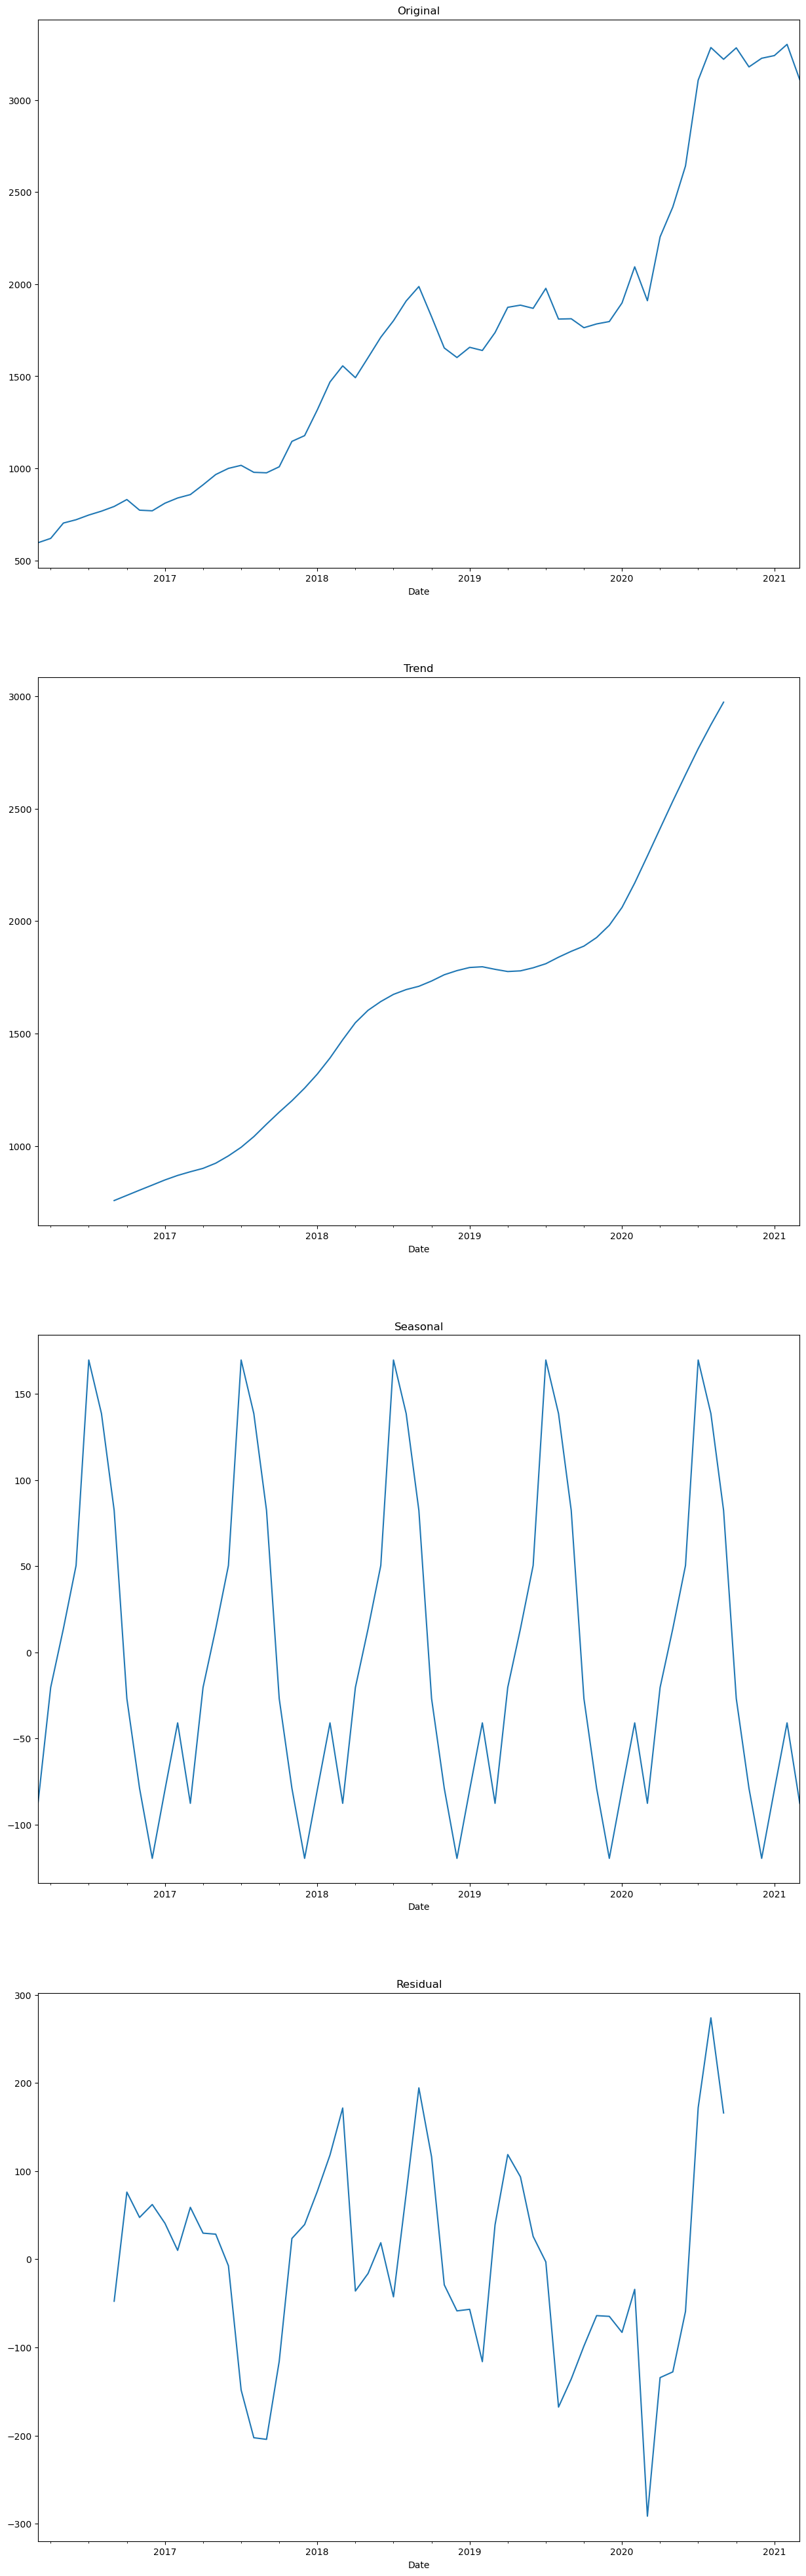

In [152]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 50))
decompose = seasonal_decompose(data_frame[['High']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

In [153]:
def is_stationary(p_value):
    print(f'p-value: {round(p_value, 4)}')
    if round(p_value, 4) > 0.05:
        print('The series is non-stationary')
    else:
        print('The series is stationary')

In [154]:
# check stationary
is_stationary(adfuller(data_frame['High'])[1])

p-value: 0.9728
The series is non-stationary


<AxesSubplot:xlabel='Date', ylabel='HighLog'>

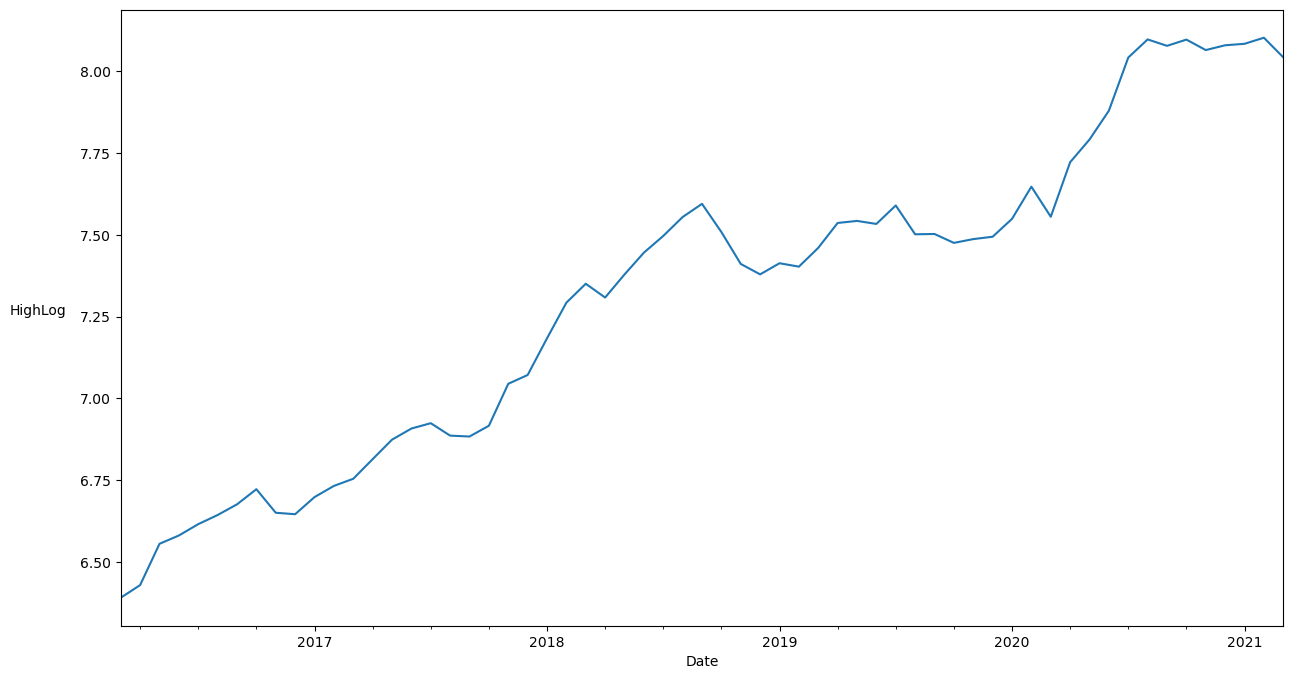

In [155]:
data_frame['HighLog'] = np.log(data_frame['High'])

plt.figure(figsize=(15, 8))
plt.ylabel('HighLog', rotation=0, labelpad=30)
data_frame['HighLog'].plot()

p-value: 0.0043
The series is stationary


<AxesSubplot:xlabel='Date', ylabel='HighLogSDiff'>

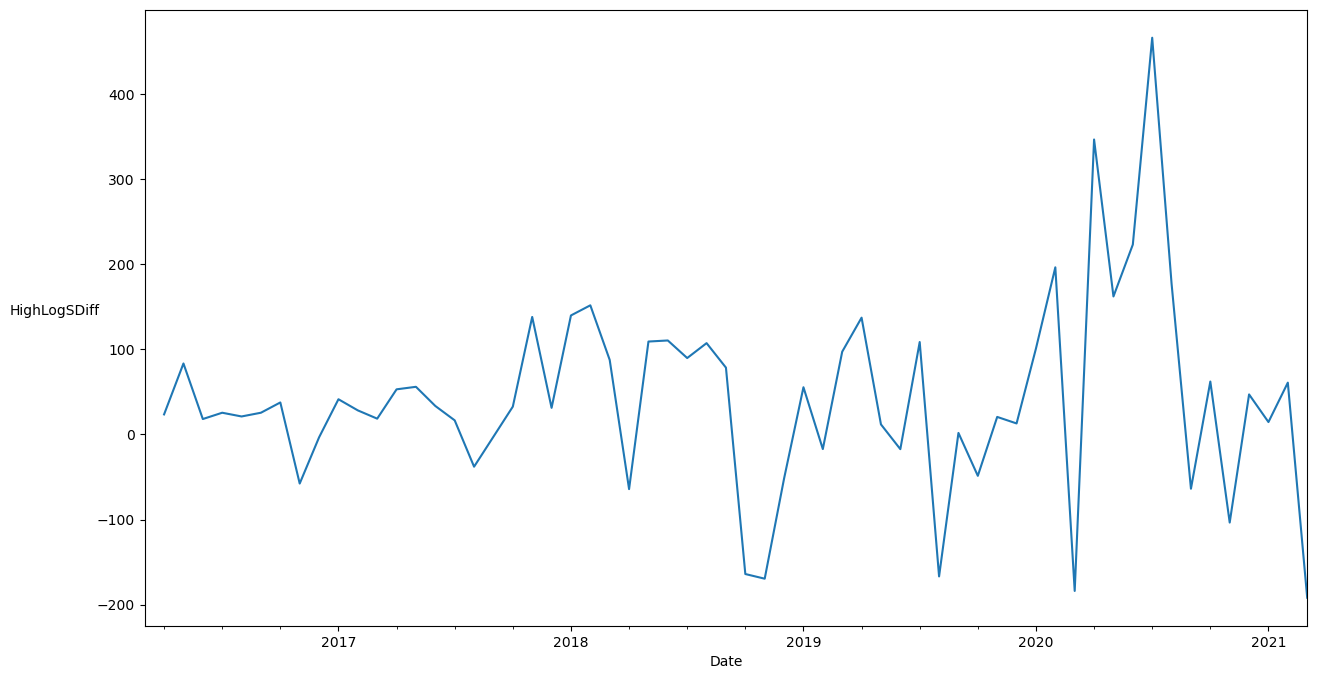

In [156]:
data_frame['HighLogSDiff'] = data_frame['High'].diff(1)

# check stationary again
is_stationary(adfuller(data_frame["HighLogSDiff"][1:])[1])

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogSDiff', rotation=0, labelpad=30)
data_frame['HighLogSDiff'].plot()

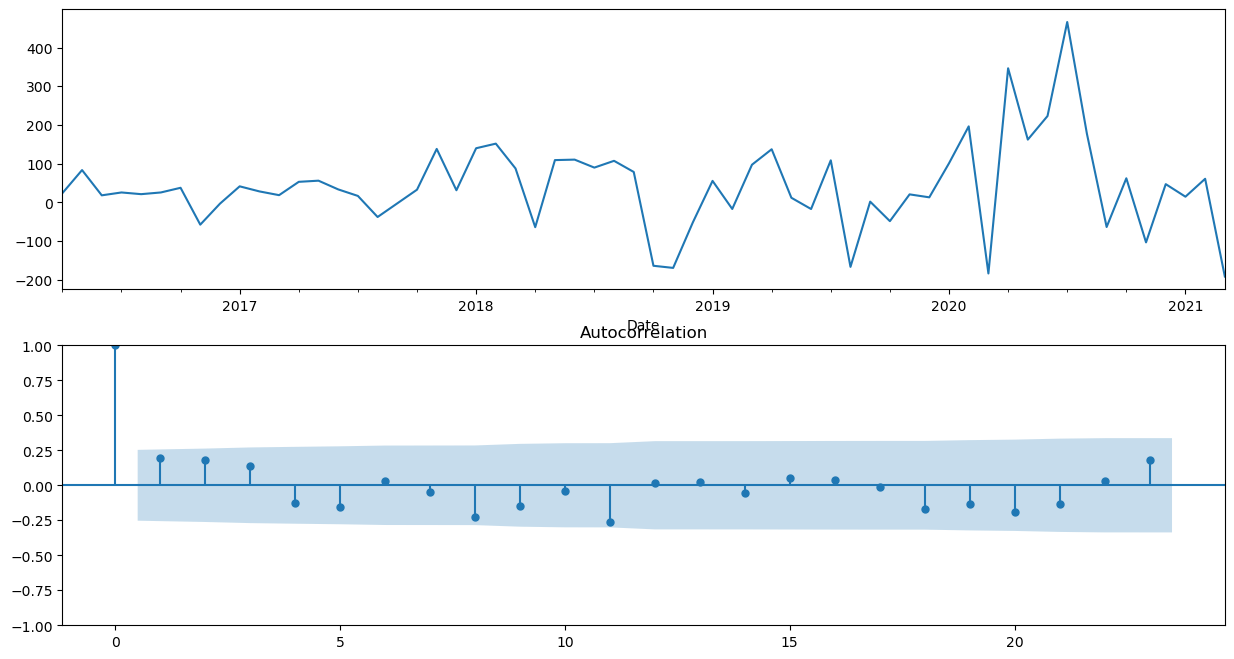

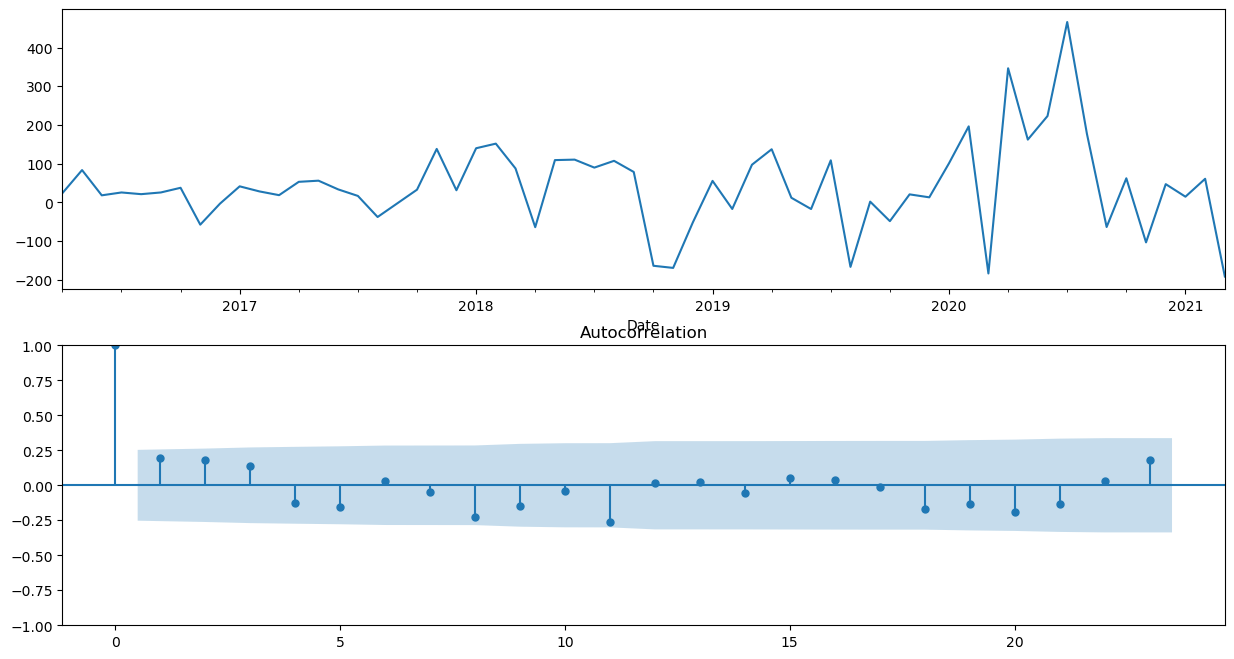

In [157]:
plt.figure(figsize=(15, 8))

ax = plt.subplot(211)
data_frame['HighLogSDiff'][1:].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(data_frame['HighLogSDiff'][1:], lags=23, ax=ax)

In [158]:
percentile = int(0.8 * len(data_frame.HighLog))

X_train = data_frame['HighLog'][:percentile]
X_test = data_frame['HighLog'][percentile:]
y_train = data_frame['High'][:percentile]
y_test = data_frame['High'][percentile:]

parameters = product(range(1, 4), range(1, 4), range(3, 5), range(0, 2), range(1, 3))
parameters_list = list(parameters)
len(parameters_list)

72

In [159]:
%%time

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    sarimax_model = sm.tsa.statespace.SARIMAX(X_train, order=(param[0], 1, param[1]), seasonal_order=(param[2], param[3], param[4], 6)).fit(disp=-1)
    aic = sarimax_model.aic
    if aic < best_aic:
        best_aic = aic
        best_param = param
        best_model = sarimax_model
    results.append([param, sarimax_model.aic])

warnings.filterwarnings('default')

100%|██████████| 72/72 [02:20<00:00,  1.95s/it]

CPU times: user 10min 49s, sys: 2min 33s, total: 13min 23s
Wall time: 2min 20s


In [160]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

         parameters         aic
4   (1, 1, 4, 0, 1) -135.529466
28  (2, 1, 4, 0, 1) -133.652753
1   (1, 1, 3, 0, 2) -133.626609
12  (1, 2, 4, 0, 1) -133.614859
5   (1, 1, 4, 0, 2) -133.586636


In [161]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           HighLog   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(4, 0, 1, 6)   Log Likelihood                  75.765
Date:                           Tue, 25 Oct 2022   AIC                           -135.529
Time:                                   19:17:52   BIC                           -120.728
Sample:                               03-31-2016   HQIC                          -129.960
                                    - 02-29-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5329      0.514      1.037      0.300      -0.474       1.540
ma.L1         -0.2105      0.629     -0.334

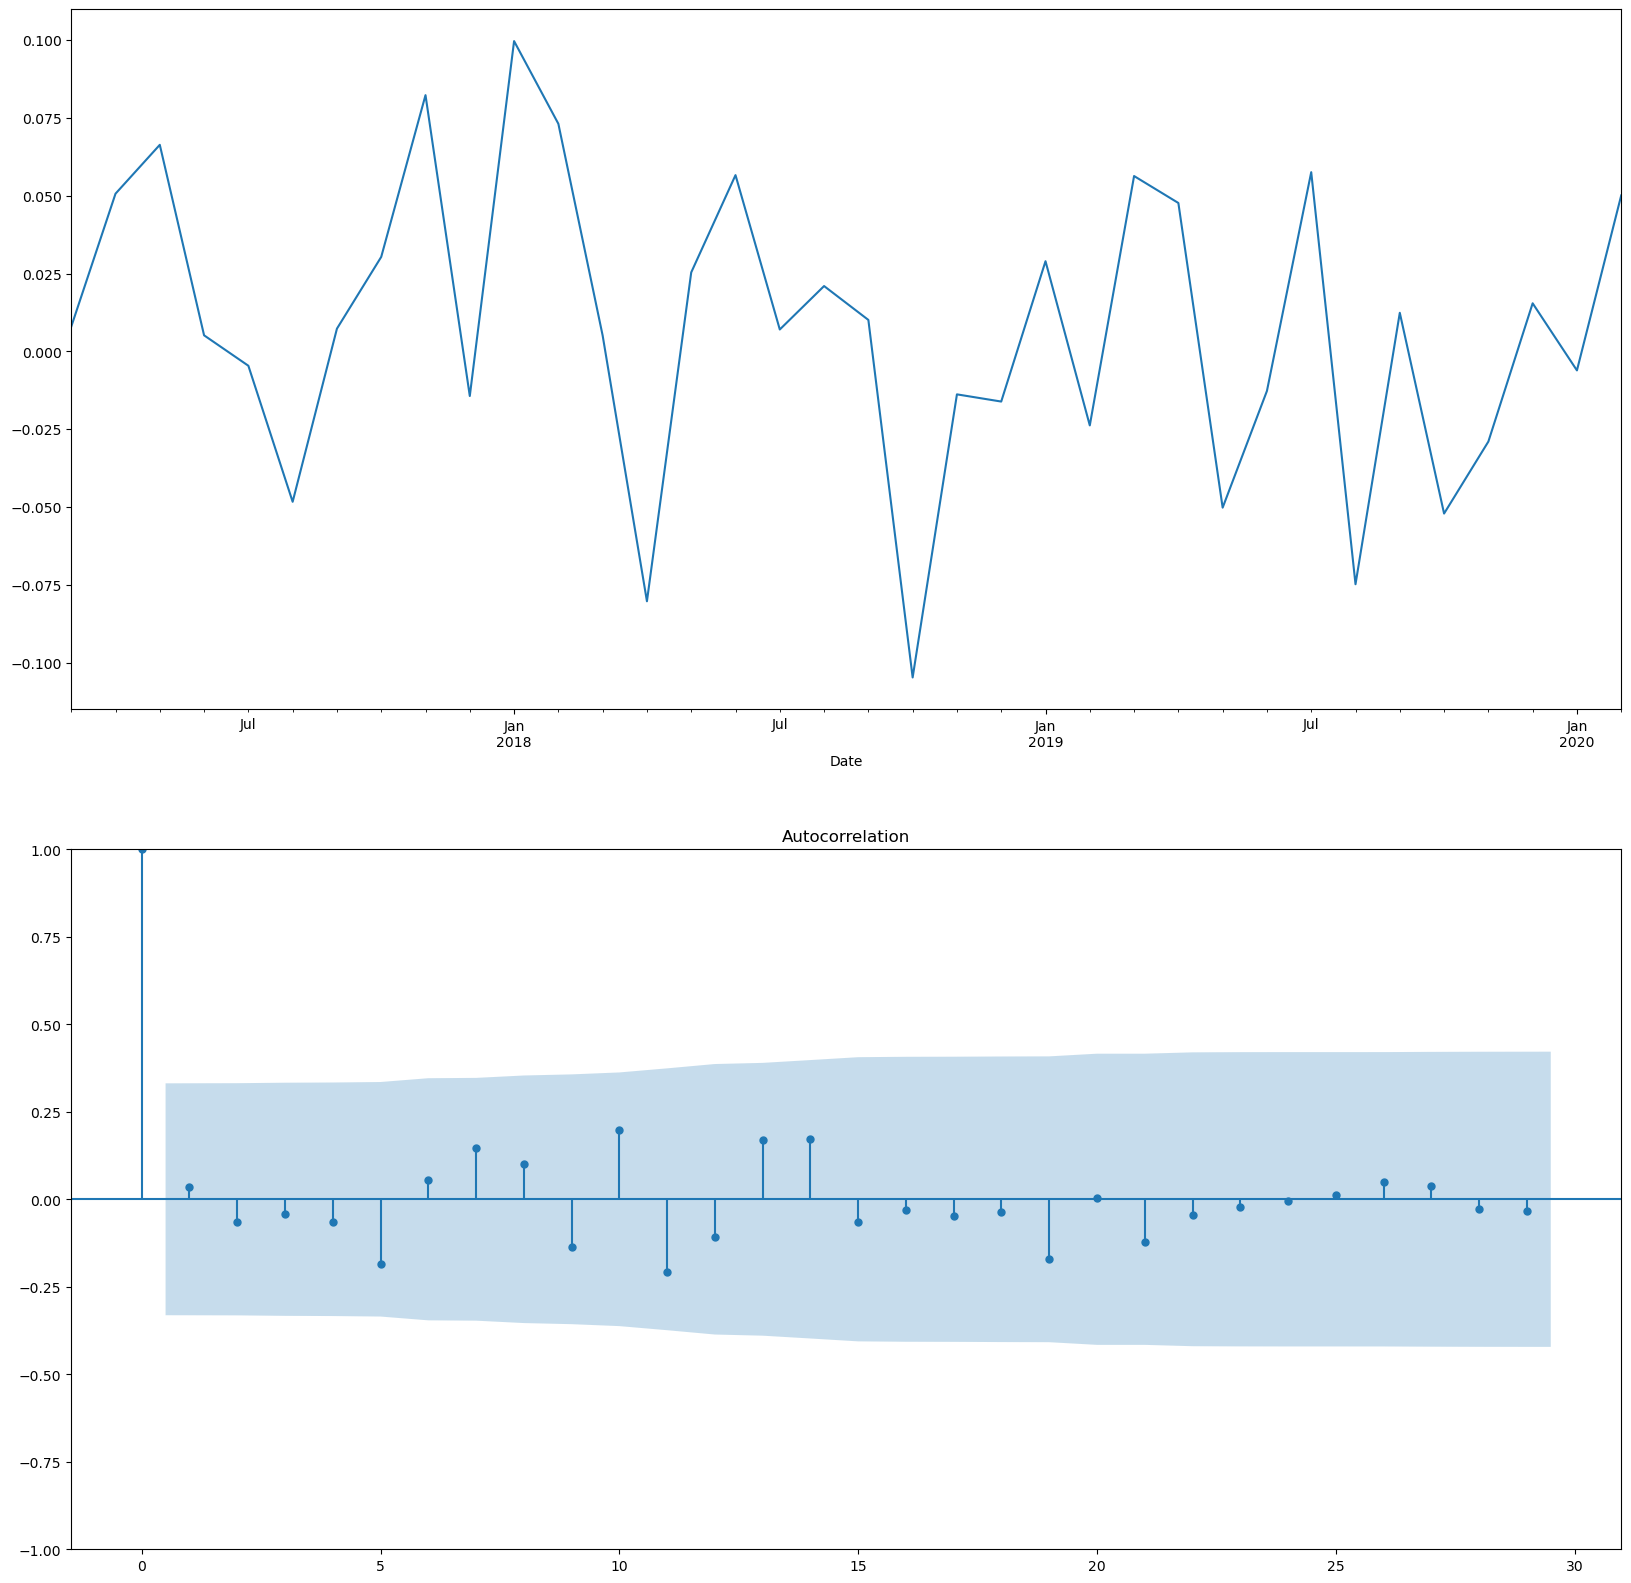

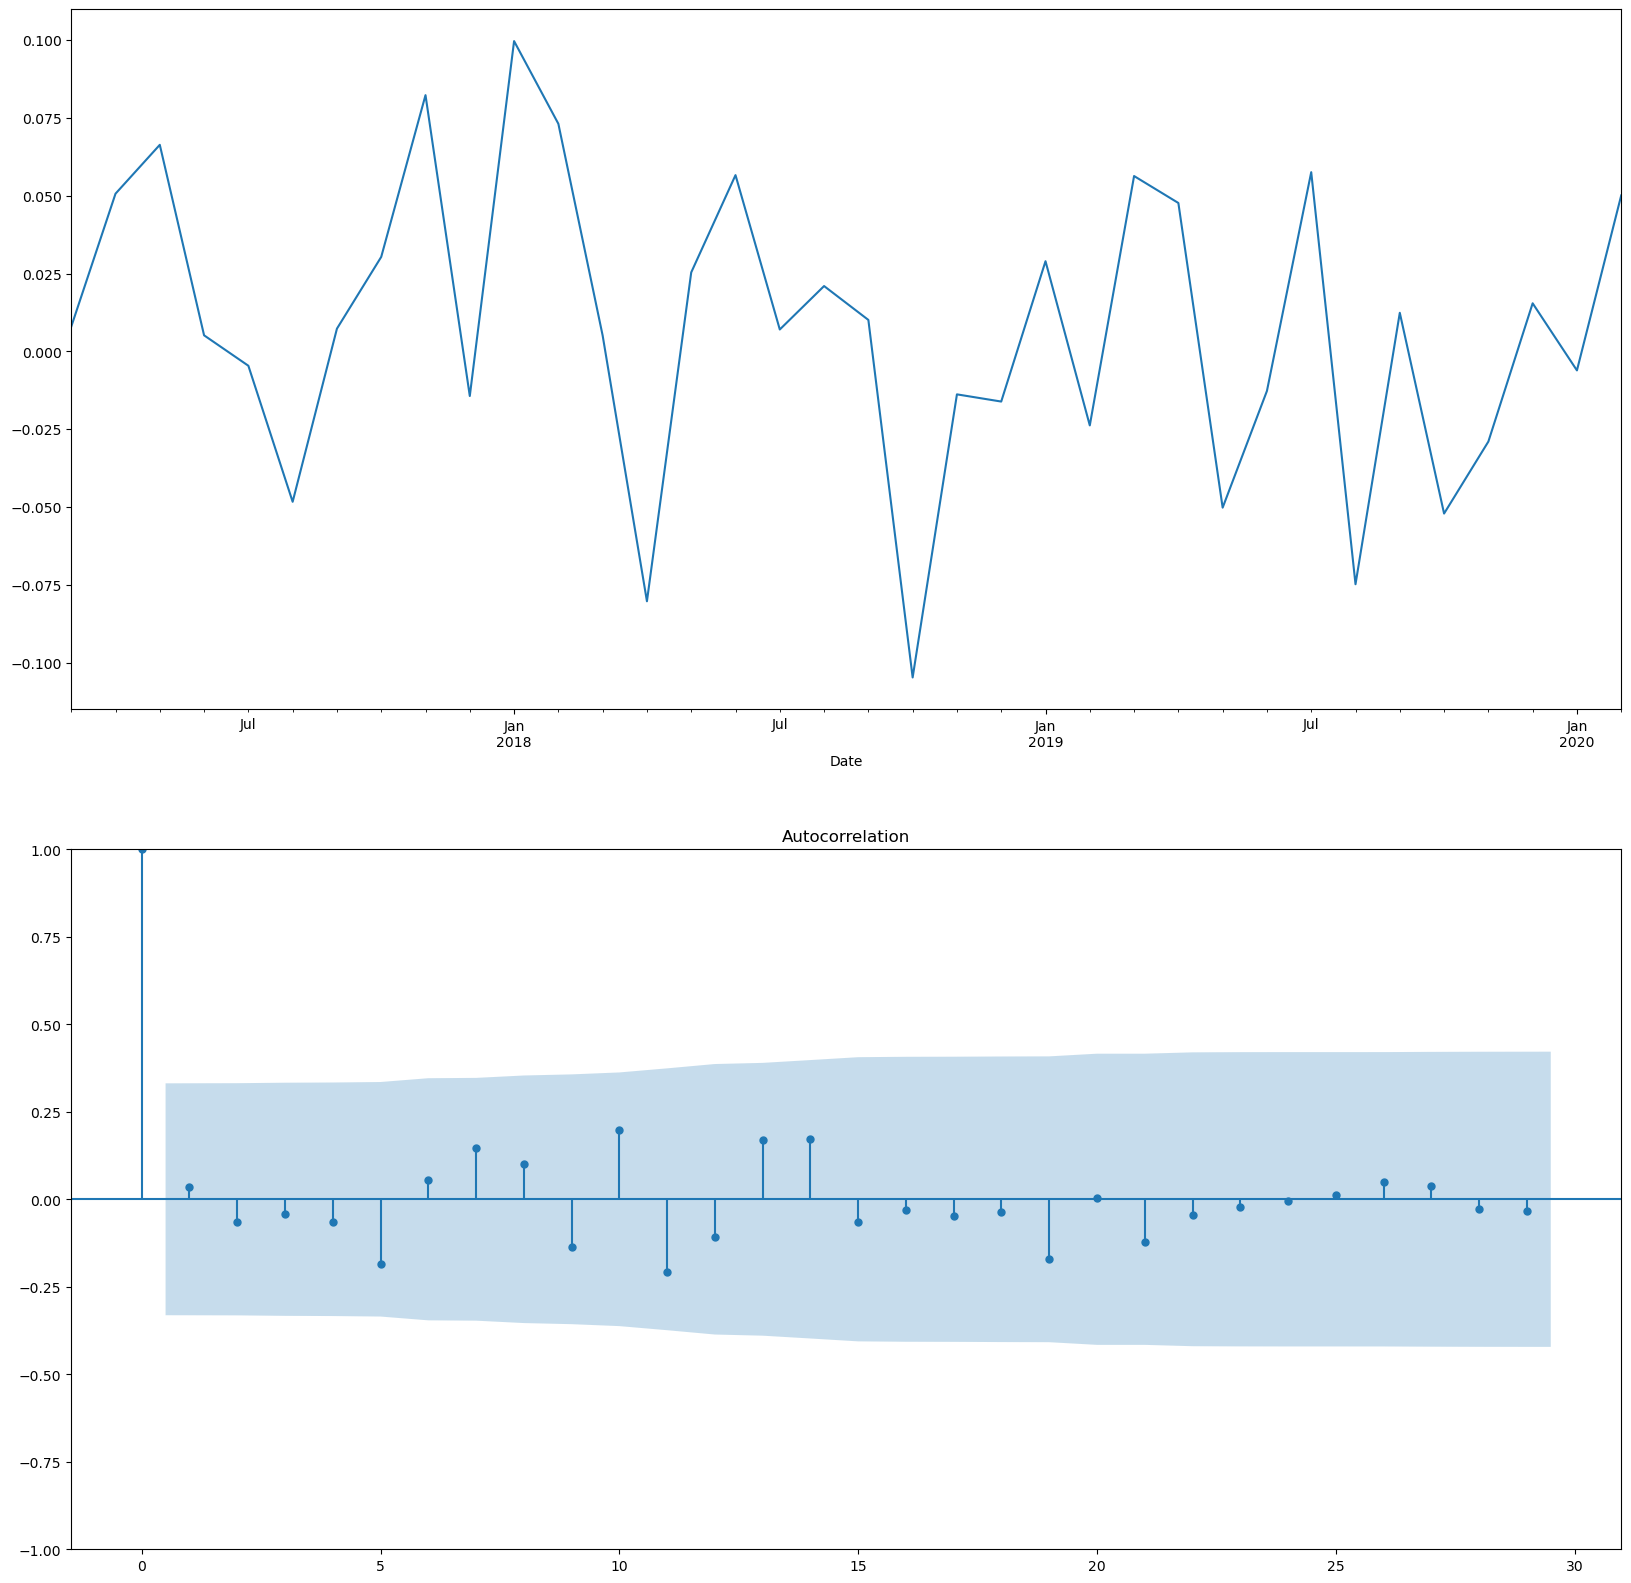

In [162]:
plt.figure(figsize=(20, 20))

plt.subplot(211)
best_model.resid[12:].plot()

ax = plt.subplot(212)
plot_acf(best_model.resid[13:].values.squeeze(), lags=29, ax=ax)

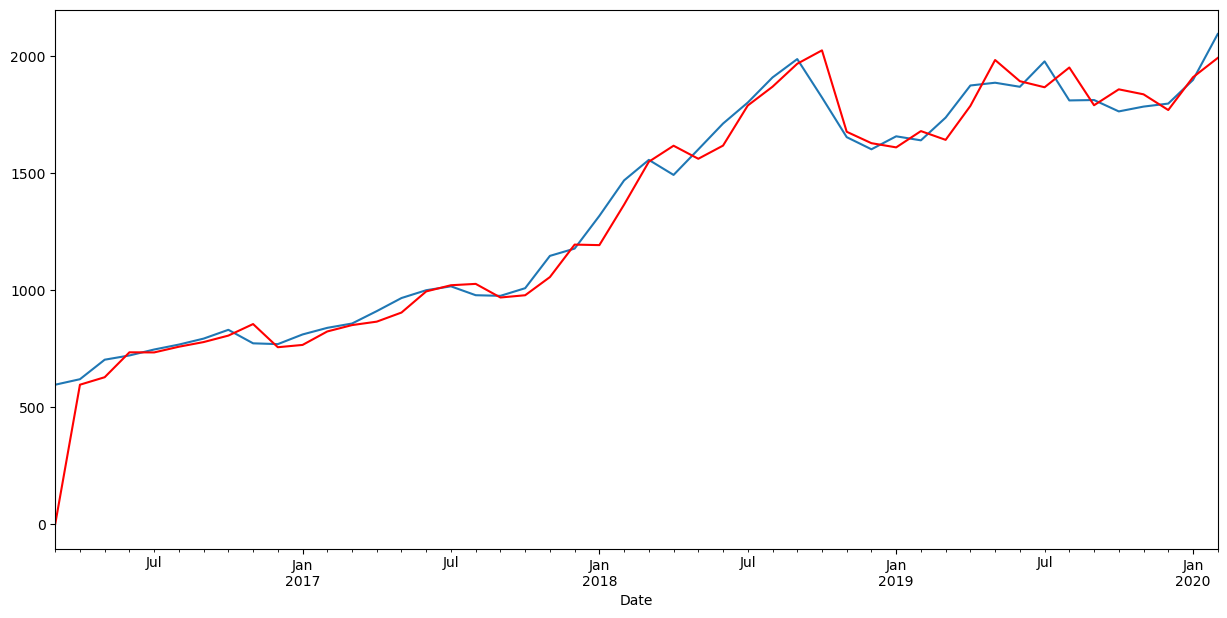

In [163]:
y_train_pred = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15, 7))

y_train.plot()
y_train_pred.plot(c='r');

In [164]:
predict_len = len(data_frame.HighLog) - percentile
data_frame['Model'] = np.exp(best_model.fittedvalues)

new_close_value = data_frame[['High', 'Model']]

future_date = [
    datetime.datetime.strptime("2019-12", "%Y-%m") + relativedelta(months=x)
    for x in range(0, predict_len)
]

future_df = pd.DataFrame(index=future_date, columns=['Value', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(74, 3)


,High,Model,Value
2020-08-01,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN
2020-12-01,NaN,NaN,NaN


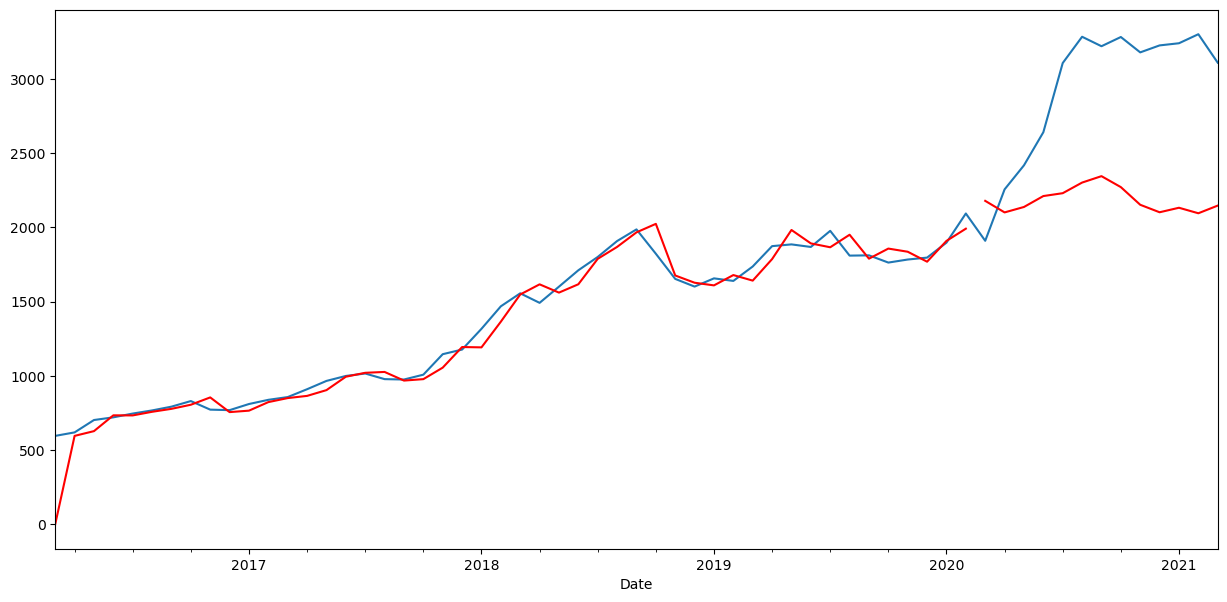

In [165]:
y_pred = np.exp(best_model.predict(start=percentile, end=percentile + len(data_frame.HighLog) - percentile - 1))

plt.figure(figsize=(15, 7))
data_frame['High'].plot()
y_pred.plot(c='r')

y_train_pred.plot(c='r');

<AxesSubplot:xlabel='Date'>

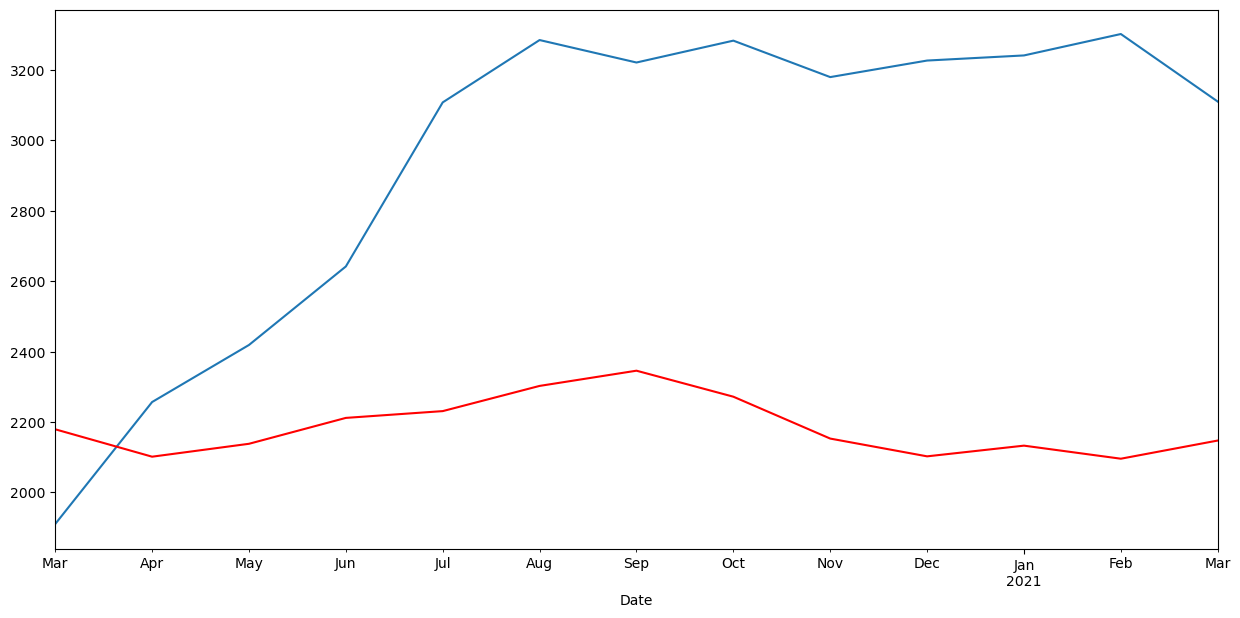

In [166]:
plt.figure(figsize=(15, 7))
y_test.plot()
y_pred.plot(c='r')

In [167]:
print(mean_absolute_percentage_error(y_pred, y_test))

0.3627422606085854


In [168]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [169]:
%%time

holt_winters_model = ExponentialSmoothing(X_train, trend='add', seasonal='add', seasonal_periods=12).fit()
best_model = holt_winters_model

CPU times: user 85.7 ms, sys: 2.61 ms, total: 88.3 ms
Wall time: 87.2 ms


In [170]:
print(best_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  HighLog   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                              0.091
Optimized:                         True   AIC                           -268.610
Trend:                         Additive   BIC                           -238.671
Seasonal:                      Additive   AICC                          -245.024
Seasonal Periods:                    12   Date:                 Tue, 25 Oct 2022
Box-Cox:                          False   Time:                         19:17:54
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

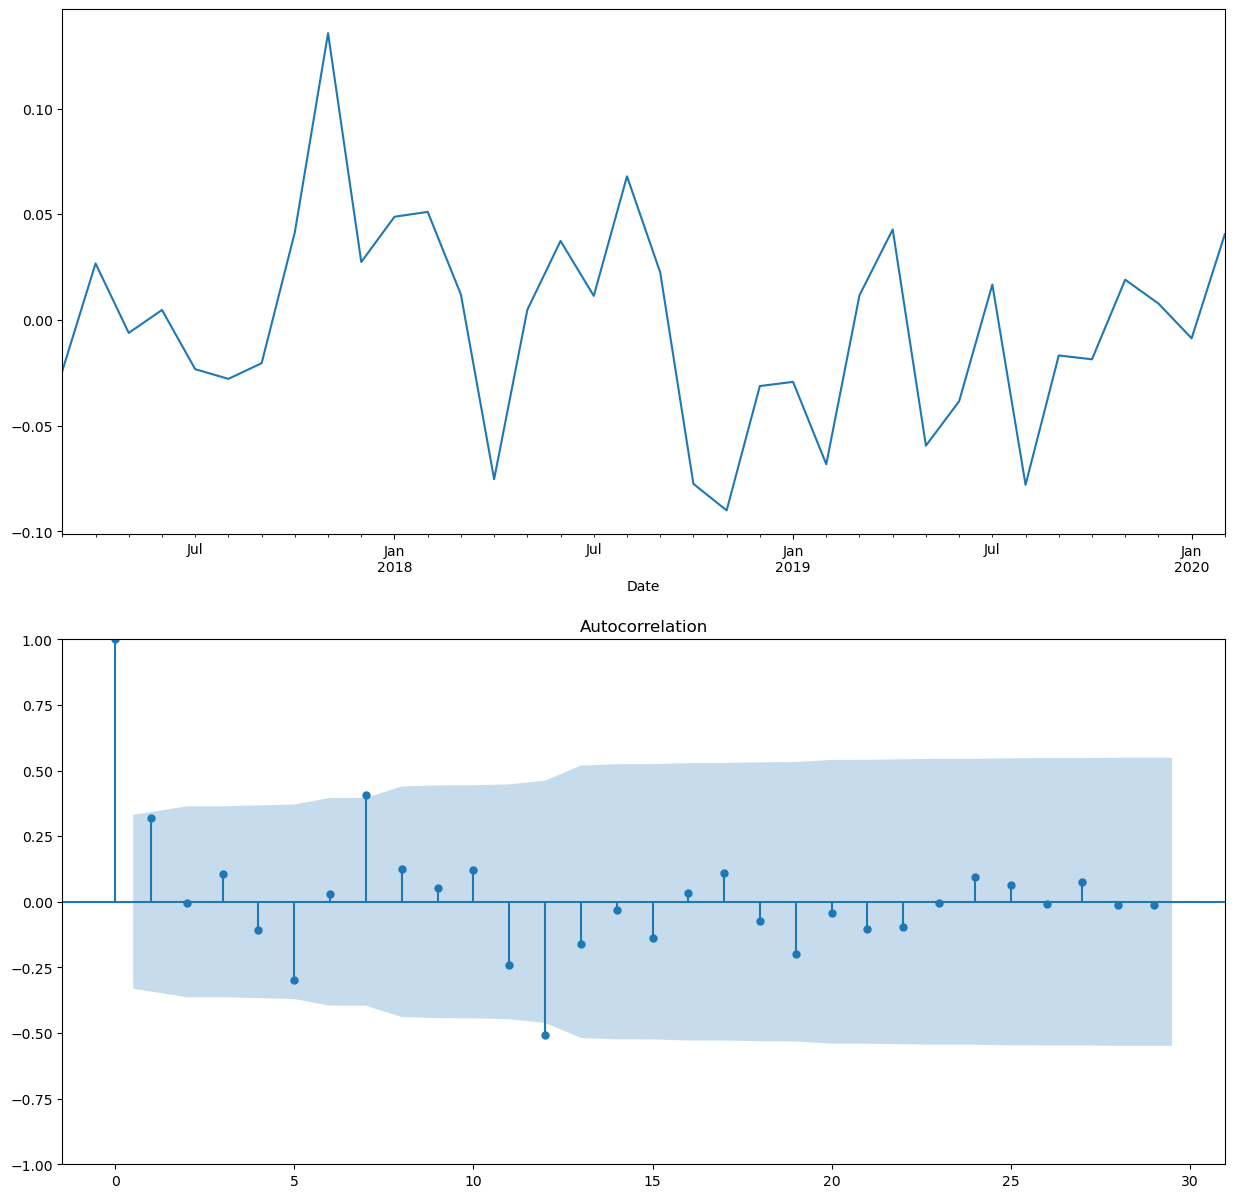

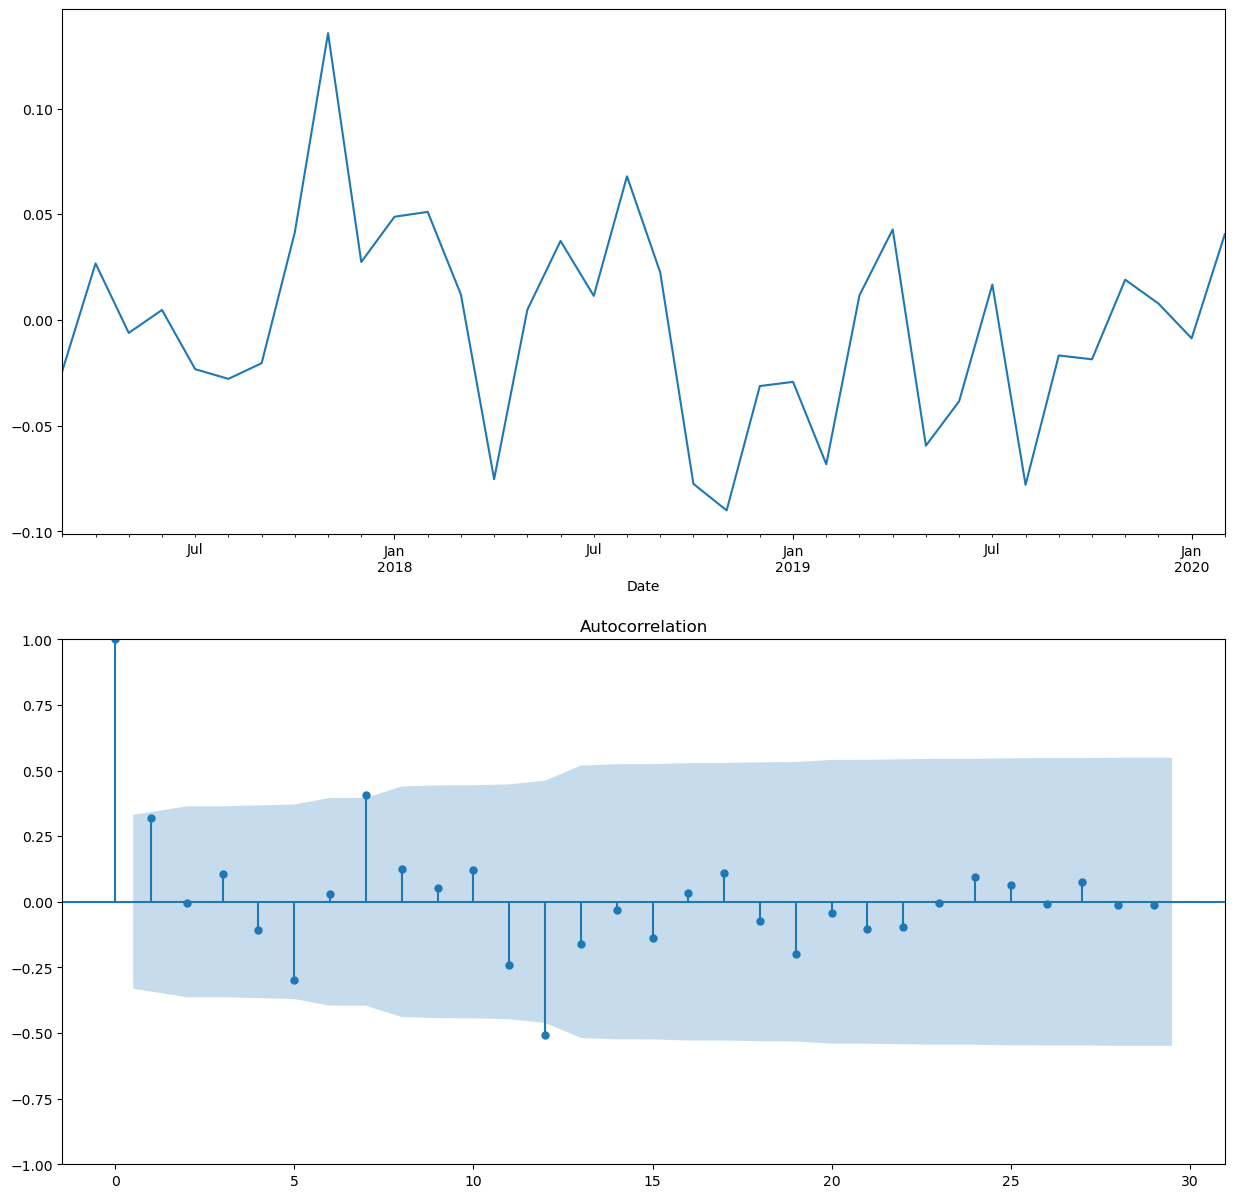

In [171]:
plt.figure(figsize=(15, 15))

plt.subplot(211)
best_model.resid[12:].plot()

ax = plt.subplot(212)
plot_acf(best_model.resid[13:].values.squeeze(), lags=29, ax=ax)

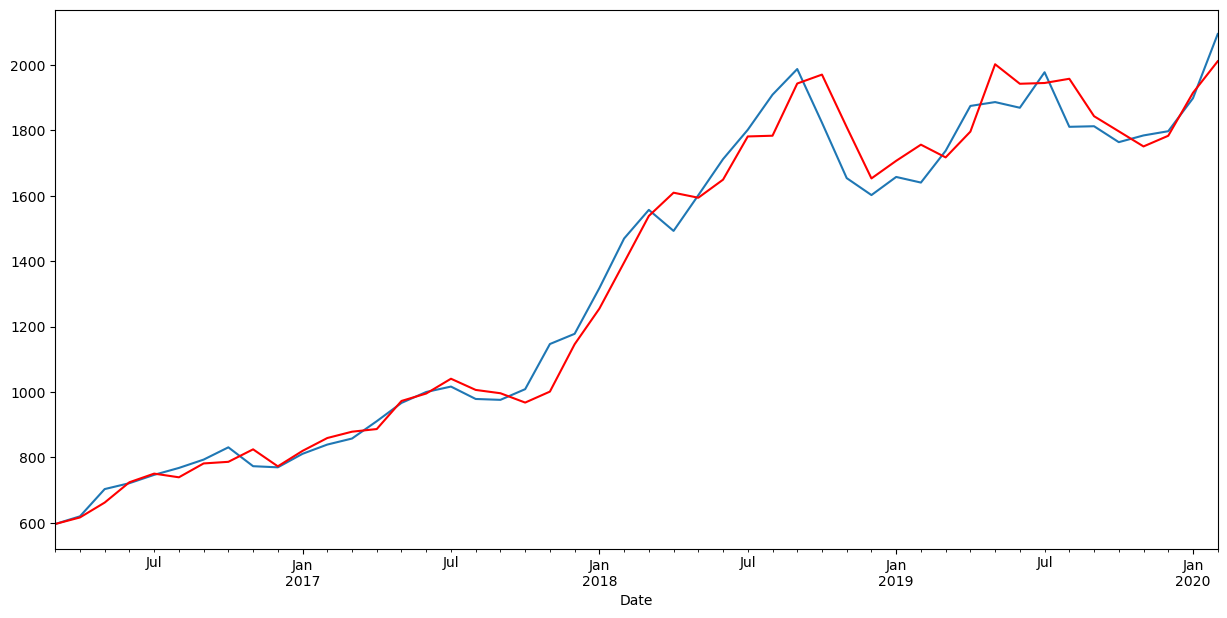

In [172]:
y_train_pred = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15, 7))

y_train.plot()
y_train_pred.plot(c='r');

In [173]:
predict_len = len(data_frame.HighLog) - percentile
data_frame['Model'] = np.exp(best_model.fittedvalues)

new_close_value = data_frame[['High', 'Model']]

future_date = [
    datetime.datetime.strptime("2019-12", "%Y-%m") + relativedelta(months=x)
    for x in range(0, predict_len)
]

future_df = pd.DataFrame(index=future_date, columns=['Value', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(74, 3)


,High,Model,Value
2020-08-01,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN
2020-12-01,NaN,NaN,NaN


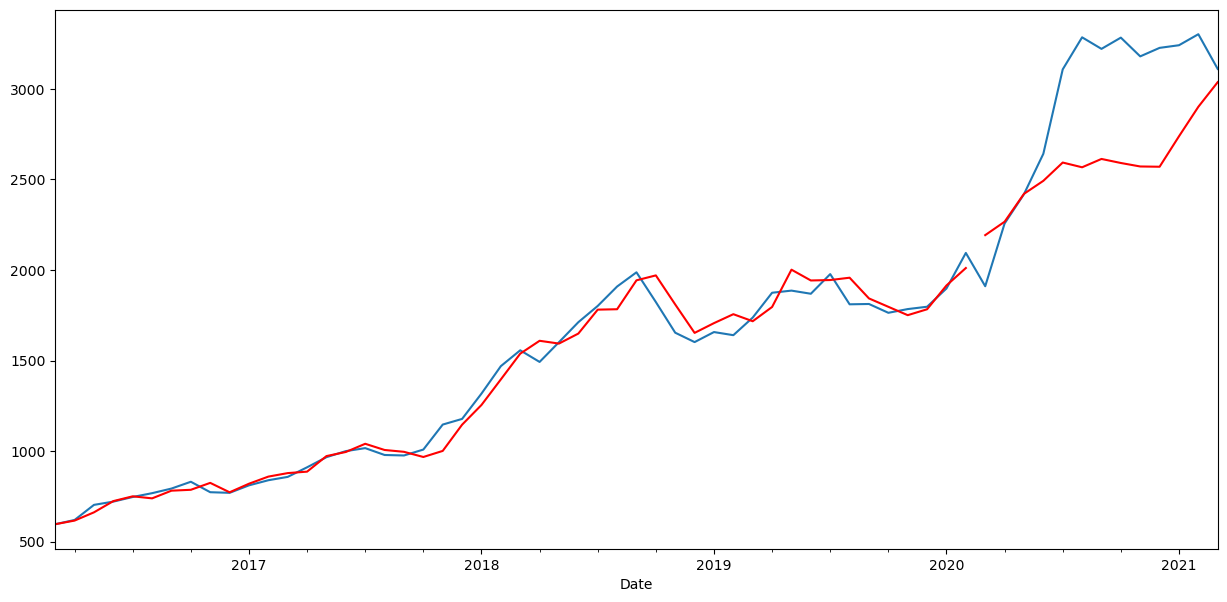

In [174]:
y_pred = np.exp(best_model.predict(start=percentile, end=percentile + predict_len - 1))

plt.figure(figsize=(15, 7))
data_frame['High'].plot()
y_pred.plot(c='r')

y_train_pred.plot(c='r');

<AxesSubplot:xlabel='Date'>

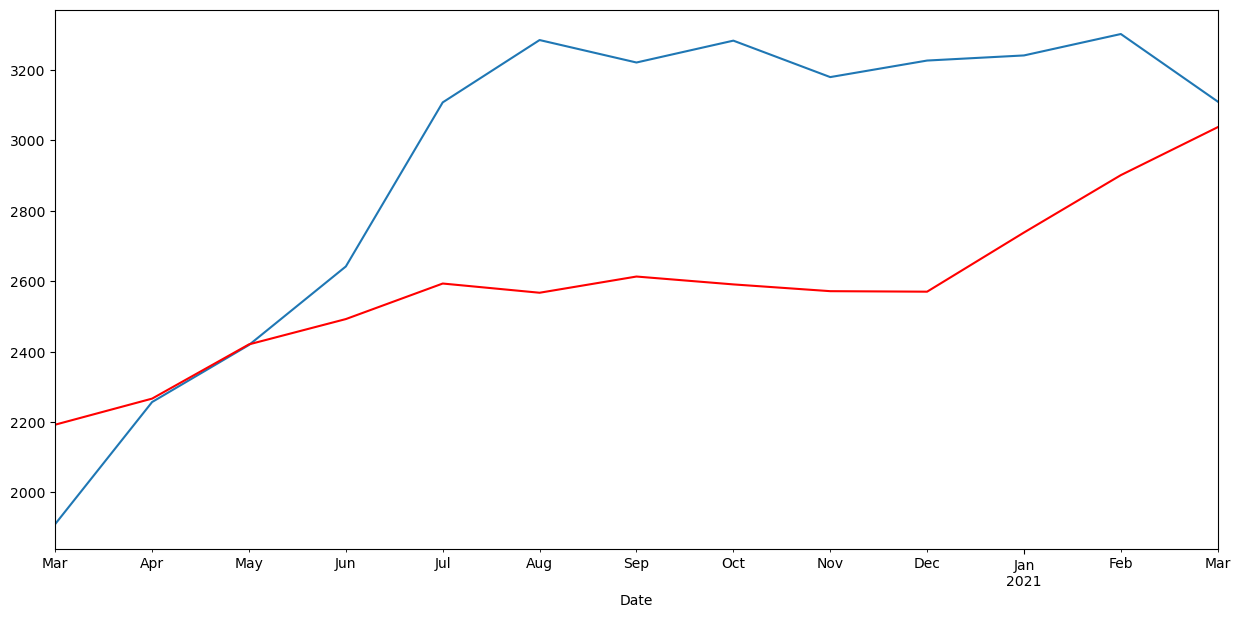

In [175]:
plt.figure(figsize=(15, 7))
y_test.plot()
y_pred.plot(c='r')

In [176]:
print(mean_absolute_percentage_error(y_pred, y_test))

0.1545364127843521
